In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df_tcga = pd.read_csv('../data/tcga.csv')
df_gtex = pd.read_csv('../data/gtex_gene_expression.csv')
df_organ = pd.read_csv('../data/gtex_tissue.csv')

In [3]:
organ_info = np.array([map(float, val.split(',')[:-1]) for val in df_gtex.rpkm_expressions.values])

In [4]:
gb_organ = df_organ.groupby('organ').groups

In [5]:
everything_list = []
organs = set(df_tcga.organ) - set(['HeadAndNeck'])
for i in tqdm(range(len(df_gtex))):
    gene_id = df_gtex['gene_id'].values[i]
    for organ in organs:
        exp = np.median(organ_info[i][gb_organ[organ]])
        everything_list.append([gene_id, organ, exp, 0])

for i in tqdm(range(len(df_tcga))):
    if not df_tcga['organ'].values[i] in organs:
        continue
    gene_id = df_tcga['gene_id'].values[i]
    organ = df_tcga['organ'].values[i]
    exp = df_tcga['fpkm_expression'].values[i]
    everything_list.append([gene_id, organ, exp, 1])
    
df_predict = pd.DataFrame(everything_list, columns = ['gene_id', 'organ', 'exp', 'is_cancer'])
    

100%|██████████| 2236128/2236128 [00:48<00:00, 46114.91it/s]


In [6]:
cancer_0_mean = np.mean(df_predict[df_predict.is_cancer == 0].exp.values)
cancer_1_mean = np.mean(df_predict[df_predict.is_cancer == 1].exp.values)
cancer_0_std = np.std(df_predict[df_predict.is_cancer == 0].exp.values)
cancer_1_std = np.std(df_predict[df_predict.is_cancer == 1].exp.values)
# cancer_0_std = np.mean(organ_info.flatten())
# tcga_norm = np.std(df_tcga.fpkm_expression)
# tcga_mean = np.mean(df_tcga.fpkm_expression)
cancer_0_mean, cancer_1_mean, cancer_0_std, cancer_1_std

(6.8334307320024203, 1.033274111195057, 191.24039033617024, 27.319230158439929)

In [7]:
gb_predict = df_predict.groupby('gene_id').groups
good_locs = []
for gene_id in tqdm(gb_predict):
    if len(set(df_predict.loc[gb_predict[gene_id], 'is_cancer'])) > 1:
        good_locs.extend(gb_predict[gene_id])

100%|██████████| 52905/52905 [00:27<00:00, 1905.31it/s]


In [8]:
df_final = df_predict.loc[good_locs, :]

In [9]:
mean_0 = np.mean(df_final[df_final.is_cancer == 0].exp)
std_0 = np.std(df_final[df_final.is_cancer == 0].exp)
mean_1 = np.mean(df_final[df_final.is_cancer == 1].exp)
std_1 = np.std(df_final[df_final.is_cancer == 1].exp)
mean_0,std_0,mean_1,std_1

(1.0084164122914123,
 8.9200362289303889,
 1.0363142485149537,
 27.363440011093203)

In [10]:
df_cancer = df_final[df_final.is_cancer == 1]
new_exp = (df_cancer.exp - mean_1)/std_1
df_cancer['exp'] = new_exp
df_not_cancer = df_final[df_final.is_cancer == 0]
new_exp = (df_not_cancer.exp - mean_0)/std_0
df_not_cancer['exp'] = new_exp

df_norm = pd.concat([df_cancer, df_not_cancer])


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import multiprocessing as mp

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
gb_norm = df_norm.groupby(['gene_id', 'organ']).groups
score_dict = {}
for key in tqdm(gb_norm):
    small_df = df_norm.loc[gb_norm[key], :]
    
    model = XGBClassifier()
    model.fit(small_df[['exp']], small_df['is_cancer'])
    score_dict[key] = roc_auc_score(small_df['is_cancer'].values, model.predict_proba(small_df[['exp']])[:,1])
    
    
    

100%|██████████| 19656/19656 [11:18<00:00, 28.96it/s]


In [44]:
sorted_ixes = np.array(list(np.argsort(score_dict.values())))

In [69]:
import matplotlib.patches as mpatches



  0%|          | 0/19656 [00:00<?, ?it/s]

('ENSG00000242922', 'Prostate')


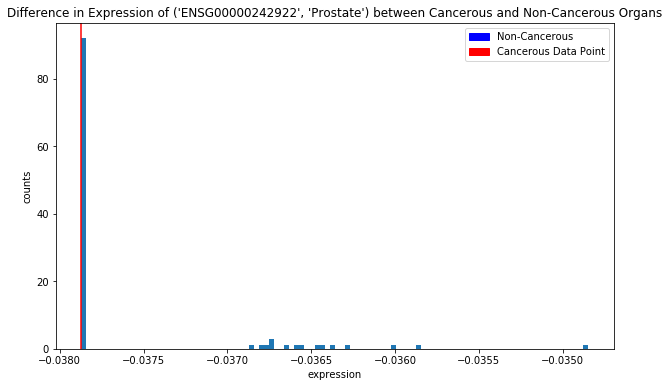

In [73]:
for i in tqdm(range(len(sorted_ixes))):
    if i > 12000:
        print tuple(np.array(score_dict.keys())[sorted_ixes[i]])
        small_df = df_norm.loc[gb_norm[tuple(np.array(score_dict.keys())[sorted_ixes[i]])], :]
        small_df = small_df[small_df.exp > -.10]
        fig = plt.figure(figsize=(10,6))
        plt.hist(small_df.exp.values, bins=100)
        plt.axvline(small_df[small_df.is_cancer == 1].exp.values[0], c='r')
        plt.xlabel('expression')
        plt.ylabel('counts')
        plt.title('Difference in Expression of ' + str(tuple(np.array(score_dict.keys())[sorted_ixes[i]])) + ' between Cancerous and Non-Cancerous Organs')
        blue_patch = mpatches.Patch(color='blue', label='Non-Cancerous')
        red_patch = mpatches.Patch(color='red', label='Cancerous Data Point')
        plt.legend(handles=[blue_patch, red_patch])
        plt.savefig('ex.png')
        plt.show()
        break

In [75]:
best_genes_dict = {}
for key in tqdm(score_dict):
    if not key[0] in best_genes_dict:
        best_genes_dict[key[0]] = []
    best_genes_dict[key[0]].append(score_dict[key])




  0%|          | 0/19656 [00:00<?, ?it/s]


100%|██████████| 19656/19656 [00:00<00:00, 218278.78it/s]

In [77]:
best_score_dict = {key: np.mean(np.log(best_genes_dict[key])) for key in best_genes_dict}

In [94]:
ixes_sorted = np.argsort(best_score_dict.values())
scores = []
for i in range(1, 51):
    print i, best_score_dict.keys()[ixes_sorted[-i]], best_score_dict.values()[ixes_sorted[-i]]
    scores.append(best_score_dict.values()[ixes_sorted[-i]])

1 ENSG00000207554 -0.00201684022083
2 ENSG00000145649 -0.00395507969427
3 ENSG00000273270 -0.00440885639688
4 ENSG00000102096 -0.00618416118831
5 ENSG00000165591 -0.00636505764117
6 ENSG00000133985 -0.00641557700344
7 ENSG00000196639 -0.0066458977513
8 ENSG00000246575 -0.00666004658487
9 ENSG00000239763 -0.00677270995259
10 ENSG00000205502 -0.00714431955518
11 ENSG00000271993 -0.00834176990876
12 ENSG00000260572 -0.00853602950174
13 ENSG00000170214 -0.00857961863196
14 ENSG00000137364 -0.00881840411458
15 ENSG00000262333 -0.00882089044185
16 ENSG00000196368 -0.00913864010692
17 ENSG00000122122 -0.00959385162522
18 ENSG00000219928 -0.00965773646269
19 ENSG00000231359 -0.00998122623398
20 ENSG00000271843 -0.0100148036785
21 ENSG00000174721 -0.0100934758949
22 ENSG00000134259 -0.0101106956163
23 ENSG00000248008 -0.010129546539
24 ENSG00000259250 -0.0101714253135
25 ENSG00000269892 -0.0107311161149
26 ENSG00000150551 -0.0108025072439
27 ENSG00000260855 -0.0108483290885
28 ENSG00000110852 -

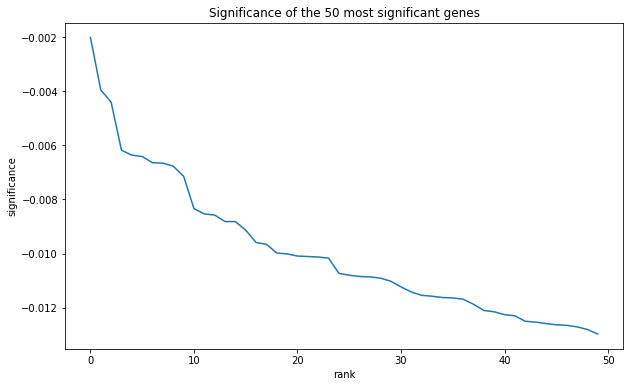

In [96]:
import seaborn
fig = plt.figure(figsize=(10,6))
plt.plot(scores)
plt.xlabel('rank')
plt.ylabel('significance')
plt.title('Significance of the 50 most significant genes')
plt.savefig('ex2.png')